In [1]:
import GPy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import scipy

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid, MultiGrid
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter

import tensorflow as tf
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
np.random.seed(123)
random.seed(123)
port = 8522

import warnings
warnings.filterwarnings("ignore")

In [2]:
def flatten(liste):
    return [item for sublist in liste for item in sublist]

def preprocessing(X_s):
    X = []
    for liste in X_s:
        X += liste.copy()
    return np.array(X)

def copie_paths(paths):
    X = []
    for liste in paths:
        X.append(liste.copy())
    return X

def copy_X_D(X_D):
    X = []
    for liste in X_D:
        X.append(liste.copy())
    return np.array(X)

def concatenate(x, y):
    if len(x)==0:
        return y
    else:
        return np.concatenate((x, y))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
        
def sigma_matrix(gp_model, X_v):
    return gp_model.kern.K(X_v, X_v)
    
def sigma_prime_matrix(gp_model, X_v, X_s):
    kernel = gp_model.rbf
    variance_n = float(gp_model.Gaussian_noise.variance)
    a = kernel.K(X_v, X_v)
    b = kernel.K(X_v, X_s)
    c = kernel.K(X_s, X_s)
    d = variance_n*np.eye(len(X_s))
    e = kernel.K(X_s, X_v)
    f = np.linalg.inv(c + d)
    g = np.dot(b, f)
    h = np.dot(g, e)
    return a - h

def reward_function(gp_model, X_v, X_s_old, X_s_new):
    if len(X_s_old)==0:
        sigma_prime_old = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_old = sigma_prime_matrix(gp_model, X_v, X_s_old)
    if len(X_s_new)==0:
        sigma_prime_new = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_new = sigma_prime_matrix(gp_model, X_v, X_s_new)
    return 0.5 * (np.log(np.linalg.det(sigma_prime_old)) - np.log(np.linalg.det(sigma_prime_new)))

def credit_assignment(env, reward, dones):
    if env.nb_agents==1:
        return np.array([reward])
    rewards = np.zeros(env.nb_agents)
    if reward==0:
        return rewards
    X_s = preprocessing(env.X_s)
    H = np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s)))
    for i in range(env.nb_agents):
        if not dones[i]:
            X_s_i = env.X_s.copy()
            del X_s_i[i]
            X_s_i = preprocessing(X_s_i)
            if len(X_s_i)==0:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_matrix(env.gp_model, env.X_v))) - H)
            else:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s_i))) - H)
    somme = np.sum(rewards)
    if somme==0:
        return rewards
    return rewards*(reward/(np.sum(rewards)))

def construct_graph(graph_dim, graph_unity):
    x = graph_dim[0]
    y = graph_dim[1]
    i, j = 0.0, 0.0
    graph = nx.Graph()
    for k in range(x*y):
        graph.add_node(k, coord=[i, j])
        i += graph_unity
        if i==x*graph_unity:
            i = 0.0
            j += graph_unity
    for k in range(x*y):
        if (k+1)%x!=0:
            graph.add_edge(k, k+1)
        if k<x*y-x:
            graph.add_edge(k, k+x)
    return graph
            
def show_graph(graph):
    nx.draw(graph, with_labels=True, font_weight='bold')

def remove_nodes_from_graph(graph, liste):
    graph.remove_nodes_from(liste)
    return graph

def incertitude_initiale(sigma, graph):
    return 0.5 * np.log(np.linalg.det(sigma)) + (graph.number_of_nodes()/2) * (1 + np.log(2*np.pi))

def coord_to_id(coord, graph_dim):
    return graph_dim[0] * int(coord[1]) + int(coord[0])

In [3]:
def collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance, lengthscale, memory_window, gamma):
    X_D = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance, lengthscale=lengthscale)
    cov = simulation_kernel.K(X_D)
    X, Y = [], []
    for _ in range(exploration_steps):
        Y_D = np.random.multivariate_normal(np.array(means), cov, 1)[0]
        Y_D = np.reshape(Y_D, (len(Y_D),1))
        Y_D[Y_D<0] = 0.1
        sparse_nodes = random.sample(range(0, graph.number_of_nodes()), nb_agents)
        sorted_nodes = sorted(sparse_nodes)
        if sorted_nodes[0]==0:
            for i in range(1,len(sorted_nodes)):
                if sorted_nodes[i]!=sorted_nodes[i-1]:
                    l = covariances[sorted_nodes[i]-1]
                    l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[0], Y_D[sorted_nodes[i]], memory_window, gamma)
        X.append(X_D[sparse_nodes])
        Y.append(Y_D[sparse_nodes])
    return incertitude_initiale(cov, graph), np.array(X), np.array(Y)

def hyperparameters_estimator(X, Y, gp_model, graph, graph_dim, memory_window, gamma):
    for i in range(len(X)):
        l = variances[coord_to_id(X[i], graph_dim)]
        l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y[i][0], memory_window, gamma)
    cumul_var = 0
    coeffs = 0
    for ele in variances:
        coeffs += ele[2]
        cumul_var += float(ele[0])*ele[2]
    variance = cumul_var/coeffs
    ###########################################
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    moyenne = np.reshape(gp_model.predict(X_v)[0], (graph.number_of_nodes(),))
    ###########################################
    lengthscale, cpt = 0, 0
    for i in range(len(covariances)):
        if covariances[i][0]>1:
            covariance = covariances[i][1] - covariances[i][2]*covariances[i][3]
            if 0<covariance<variance:
                cpt += covariances[i][0]
                lengthscale += find_lengthscale(X_v[0], X_v[i+1], covariance, variance) * covariances[i][0]
    if cpt!=0:
        lengthscale /= cpt
    else:
        lengthscale = 0
    return moyenne, variance, lengthscale

def find_lengthscale(x1, x2, y, var):
    return distance(x1, x2) * np.sqrt(-0.5/np.log(y/var))

def weighted_covariance(n, moy_prod, moy_x, moy_y, x_new, y_new, memory_capacity, gamma):
    if n>memory_capacity:
        return n + 1, gamma * moy_prod + (1-gamma) * x_new * y_new, gamma * moy_x + (1-gamma) * x_new, gamma * moy_y + (1-gamma) * y_new
    return n + 1, (n * moy_prod + x_new * y_new)/(n + 1), (n * moy_x + x_new)/(n + 1), (n * moy_y + y_new)/(n + 1)

def weighted_variance(var, moy, n, x_new, memory_capacity, gamma):
    if n>memory_capacity:
        a = gamma*(var+(moy**2)) + (1-gamma)*(x_new**2)
        moy = gamma * moy + (1-gamma) * x_new
    else:
        a = (n*(var+(moy**2)) + (x_new**2))/(n+1)
        moy = (n*moy+x_new)/(n+1)
    return a-moy**2, moy, n+1

In [4]:
graph_dim = (5, 5)
graph_unity = 1
graph = construct_graph(graph_dim, graph_unity)
X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
means = [60, 30, 20, 15, 10, 30, 27.5, 25, 17.5, 11.25, 20, 25, 22.5, 20, 12.5, 15, 17.5, 20, 17.5, 15, 10, 11.25, 12.5, 15, 12.5]
nb_agents = 3
exploration_steps = 25
variance_lengthscale = [10, 2]
memory_window = 1000
gamma = 0.997

variances = [[0, 0, 0] for _ in range(graph.number_of_nodes())]
covariances = [[0, 0, 0, 0] for _ in range(graph.number_of_nodes()-1)]

incertitude, x, y = collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance_lengthscale[0], variance_lengthscale[1], memory_window, gamma)

x = np.reshape(x, (nb_agents*exploration_steps,2))
y = np.reshape(y, (nb_agents*exploration_steps,1))

gp_model = GPy.models.GPRegression(x, y, GPy.kern.RBF(2))
gp_model.optimize(messages=False)

moyenne, var, l = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
print("Variance: ", var)
print("Lengthscale: ", l)
print("Carte: ", moyenne)
print("Incertitude initiale : ", incertitude_initiale(sigma_matrix(gp_model, X_v), graph))

Variance:  6.630500994933553
Lengthscale:  [1.33462695]
Carte:  [61.42182314 30.70830029 18.24825012 14.60216164 11.17113024 32.32974597
 23.91409301 24.45371176 18.73139786 10.29112404 18.15012332 21.01698463
 24.29303785 17.92047225 10.56134434 13.03002171 15.47067502 18.72326228
 18.00522531 16.03398151  9.67046301 11.76729391 15.56039682 15.7214703
 11.54153804]
Incertitude initiale :  81.94223693030234


In [5]:
def update_gp_model(gp_model, x, y, graph, graph_dim, memory_window, gamma, display_gp_model=False):
    moy, variance, lengthscale = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
    X = np.concatenate((gp_model.X, x))[-1000:]
    Y = np.concatenate((gp_model.Y, y))[-1000:]
    gp_model.set_XY(X, Y)
    gp_model.optimize(messages=False)
    if display_gp_model:
        display(gp_model)
    return gp_model, moy, variance, lengthscale

def take_measurements(nodes, means, X_v, memory_window, gamma):
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance_lengthscale[0], lengthscale=variance_lengthscale[1])
    cov = simulation_kernel.K(X_v)
    Y_v = np.random.multivariate_normal(np.array(means), cov, 1)[0]
    Y_v = np.reshape(Y_v, (len(Y_v),1))
    Y_v[Y_v<0] = 0.1
    sorted_nodes = sorted(nodes)
    if sorted_nodes[0]==0:
        for i in range(1,len(sorted_nodes)):
            if sorted_nodes[i]!=sorted_nodes[i-1]:
                l = covariances[sorted_nodes[i]-1]
                l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[0], Y_v[sorted_nodes[i]], memory_window, gamma)
    return X_v[nodes], Y_v[nodes]

In [13]:
class pfeEnv(py_environment.PyEnvironment):

    def __init__(self, graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, variance_0, lengthscale_0, memory_window, gamma, train_env=True):
        self.nb_agents = nb_agents
        self.graph = graph
        self.graph_unity = graph_unity
        self.graph_dim = graph_dim
        self.initial_budgets = budgets/self.graph_unity
        self.budgets = self.initial_budgets.copy()
        if initial_positions!=None:
            self.initial_positions = copie_paths(initial_positions)
            self.paths = copie_paths(initial_positions)
        else:
            self.initial_positions = None
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        self.X_v = np.array([self.graph.nodes[i]["coord"] for i in range(self.graph.number_of_nodes())])
        self.gp_model = gp_model
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.nb_agents*2,), dtype=np.float32, minimum=np.zeros((self.nb_agents*2,)), name="observation")
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self._episode_ended = False
        #################################
        self.cpt_update_gp_model = 0
        self.memory_window, self.gamma = memory_window, gamma
        self.x, self.y = np.array([]), np.array([])
        self.liste_variances, self.liste_lengthscales = [variance_0], [lengthscale_0]
        self.train_env = train_env
        self.agents_in_collision = []
        
    def current_node(self, id_agent):
        return self.paths[id_agent][-1]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def current_node_coord(self, id_agent):
        coord = self.graph.nodes[self.current_node(id_agent)]["coord"]
        return (int(coord[0]), int(coord[1]))
    
    def formater(self):
        for i in range(len(self.neighbors)):
            liste = self.neighbors[i]
            node = self.current_node(i)
            try:
                if liste[0]>=node-1:
                    liste.insert(0,-1)
                if liste[1]!=node-1:
                    liste.insert(1,-1)
                if liste[2]!=node+1:
                    liste.insert(2,-1)
            except:
                pass
            for _ in range(4-len(liste)):
                liste.append(-1)

    def _reset(self):
        if self.initial_positions!=None:
            self.paths = copie_paths(self.initial_positions)
        else:
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)] 
        self.formater()
        self.budgets = self.initial_budgets.copy()
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
        
    def _step(self, abstract_actions):
        if self._episode_ended:
            return self.reset()
        actions = []
        for i in range(self.nb_agents):
            actions.append(self.neighbors[i][abstract_actions[i]])
        X_s_old = preprocessing(self.X_s)
        for i in range(self.nb_agents):
            if not self.dones[i]:
                if actions[i]!=-1:
                    self.X_s[i].append([graph.nodes[actions[i]]["coord"][0], graph.nodes[actions[i]]["coord"][1]])
                    self.budgets[i] -= 1
                else:
                    actions[i] = self.current_node(i)
                    self.budgets[i] -= 0.3
                if self.budgets[i]<1:
                    self.dones[i] = True
                    self.cpt_done += 1
                self.paths[i].append(actions[i])
                coord = self.graph.nodes[self.current_node(i)]["coord"]
                self._state[2*i] = coord[0]
                self._state[2*i+1] = coord[1]
        
        if self.train_env:
            positions, mesures = take_measurements(actions, means, self.X_v, self.memory_window, self.gamma)
            self.x = concatenate(self.x, positions)
            self.y = concatenate(self.y, mesures)
            self.cpt_update_gp_model = (self.cpt_update_gp_model + 1)%100
            if self.cpt_update_gp_model==0:
                self.gp_model, m, var, l = update_gp_model(self.gp_model, self.x, self.y, self.graph, self.graph_dim, self.memory_window, self.gamma)
                self.liste_variances.append(var)
                self.liste_lengthscales.append(l)
                self.moy = m
                self.x, self.y = np.array([]), np.array([])
        
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        reward = reward_function(self.gp_model, self.X_v, X_s_old, preprocessing(self.X_s))
        if self.cpt_done==self.nb_agents:
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=0.97)

In [14]:
num_iterations = 10000
fc_layer_params = (128,64,)
replay_buffer_capacity = 300000
batch_size = 128
learning_rate = 1e-5

num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 3
gamma = 0.99

num_eval_episodes = 10
log_eval_interval = 1000

max_episode_length = 25
budgets = 25 * np.ones(nb_agents)

In [40]:
initial_positions = None #[[random.randint(0, graph.number_of_nodes()-1)] for i in range(nb_agents)]
train_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=True), duration=max_episode_length)
eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=False), duration=max_episode_length)
mesa_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=True), duration=max_episode_length)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
mesa_env = tf_py_environment.TFPyEnvironment(mesa_py_env)

agents_tf = []
eval_policies = []
collect_policies = []
policies_checkpointers = []

for i in range(nb_agents):
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        fc_layer_params=fc_layer_params)
        
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    agents_tf.append(categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update=n_step_update,
        target_update_period=5,
        target_update_tau=0.05,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter))

    agents_tf[-1].initialize()

    eval_policies.append(agents_tf[-1].policy)
    collect_policies.append(agents_tf[-1].collect_policy)
    
    policies_checkpointers.append(common.Checkpointer(ckpt_dir='Meza_Inference_Politique_'+str(i), policy=eval_policies[-1]))

In [16]:
def compute_avg_return(environment, policies, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(policies[i].action(time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, environment_py, policies):
    time_step = environment.current_time_step()
    actions = []
    actions_step = []
    dones = environment_py.dones.copy()
    for i in range(nb_agents):
        actions_step.append(policies[i].action(time_step))
        actions.append(actions_step[-1].action.numpy()[0])
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)
    rewards = credit_assignment(environment_py, next_time_step.reward.numpy()[0], dones)
    for i in range(nb_agents):
        if not dones[i]:
            nts = next_time_step._replace(reward=tf.convert_to_tensor([rewards[i]], dtype=np.float32))
            traj = trajectory.from_transition(time_step, actions_step[i], nts)
            replay_buffers[i].add_batch(traj)

In [17]:
replay_buffers = []
for i in range(nb_agents):
    replay_buffers.append(tf_agents.replay_buffers.TFUniformReplayBuffer(
        data_spec = agents_tf[i].collect_data_spec,
        batch_size = train_env.batch_size,
        max_length = replay_buffer_capacity))

iterators = []
for i in range(nb_agents):
    dataset = replay_buffers[i].as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=2).prefetch(3)

    iterators.append(iter(dataset))

In [18]:
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []
err = []

for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(500)):
    collect_step(train_env, train_py_env, collect_policies)
    
for step in tqdm(range(1, num_iterations+1)):
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
    
    for i in range(nb_agents):
        experience, _ = next(iterators[i])
        agents_tf[i].train(experience=experience)

    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print("Variance : ", train_py_env.liste_variances[-1])
        print("Lengthscale : ", train_py_env.liste_lengthscales[-1])
        err.append(np.mean((train_py_env.moy-means)**2))
        print("MSE de la moyenne : ", err[-1])

14.14046


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
 10%|███████▋                                                                     | 1003/10000 [01:11<55:36,  2.70it/s]

step = 1000: Average Return = 12.150976181030273
Variance :  10.446393067860985
Lengthscale :  [2.3804683]
MSE de la moyenne :  1.6691729808851332


 20%|███████████████▍                                                             | 2003/10000 [02:26<59:52,  2.23it/s]

step = 2000: Average Return = 13.731318473815918
Variance :  9.967941958608003
Lengthscale :  [2.33152703]
MSE de la moyenne :  32.860536043521826


 30%|███████████████████████▏                                                     | 3004/10000 [03:39<41:36,  2.80it/s]

step = 3000: Average Return = 15.836660385131836
Variance :  10.352956289717962
Lengthscale :  [2.37870005]
MSE de la moyenne :  13.583119124943288


 40%|██████████████████████████████▊                                              | 4004/10000 [04:52<36:06,  2.77it/s]

step = 4000: Average Return = 37.2549934387207
Variance :  10.057641285712606
Lengthscale :  [2.43289531]
MSE de la moyenne :  4.958543506446828


 50%|██████████████████████████████████████▌                                      | 5002/10000 [06:09<42:07,  1.98it/s]

step = 5000: Average Return = 28.419185638427734
Variance :  9.95204766910792
Lengthscale :  [2.52215314]
MSE de la moyenne :  0.31946700192522093


 60%|██████████████████████████████████████████████▏                              | 6003/10000 [07:25<25:15,  2.64it/s]

step = 6000: Average Return = 30.206005096435547
Variance :  9.704917536829907
Lengthscale :  [2.14139052]
MSE de la moyenne :  0.4028039671780938


 70%|█████████████████████████████████████████████████████▉                       | 7002/10000 [08:39<23:02,  2.17it/s]

step = 7000: Average Return = 27.8193302154541
Variance :  10.028797851924185
Lengthscale :  [2.18522876]
MSE de la moyenne :  1.2001778135870602


 80%|█████████████████████████████████████████████████████████████▌               | 8003/10000 [09:49<11:36,  2.87it/s]

step = 8000: Average Return = 29.488811492919922
Variance :  10.01004005777529
Lengthscale :  [2.03626913]
MSE de la moyenne :  0.39873675332369546


 90%|█████████████████████████████████████████████████████████████████████▎       | 9001/10000 [11:04<08:30,  1.96it/s]

step = 9000: Average Return = 32.085147857666016
Variance :  9.917304423544104
Lengthscale :  [2.03539823]
MSE de la moyenne :  0.9479413374128446


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [12:16<00:00, 13.57it/s]

step = 10000: Average Return = 32.451839447021484
Variance :  9.954908702948185
Lengthscale :  [2.06062099]
MSE de la moyenne :  1.019219043201156


(25.944427, 19.68109974825392, 32.20775523221483)


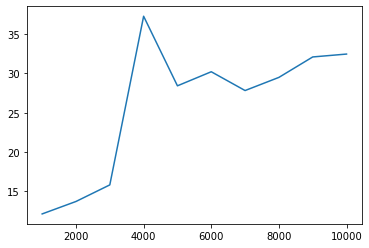

In [19]:
print(mean_confidence_interval(avg, confidence=0.95))
plt.plot(steps, avg)

In [23]:
total_return = 0.0
episodes = 1
for _ in range(episodes):
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = []
        for i in range(nb_agents):
            actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        episode_return += time_step.reward
    print(eval_py_env.paths)
    print(episode_return.numpy()[0])
    print("##################################")
    total_return += episode_return
avg_return = total_return / episodes
print("Moyenne : ", avg_return.numpy()[0])

[[6, 11, 16, 21, 16, 11, 6, 7, 2, 1, 0, 5, 10, 11, 6, 7, 2, 3, 2, 1, 6, 1, 0, 5, 10, 11], [8, 13, 18, 17, 16, 15, 16, 11, 6, 11, 6, 11, 16, 11, 10, 5, 6, 1, 6, 1, 6, 11, 6, 11, 16, 11], [7, 6, 11, 16, 21, 16, 17, 22, 21, 20, 20, 20, 20, 21, 22, 23, 24, 23, 22, 21, 20, 20, 20, 20, 20, 21]]
32.054867
##################################
Moyenne :  32.054867


In [24]:
for i in range(nb_agents):
    policies_checkpointers[i].save(global_step=agents_tf[i].train_step_counter)

## Partie Visualisation Mesa

In [105]:
class VizAgent(Agent):
    def __init__(self, id_agent, pos, model, agent_type):
        super().__init__(id_agent, model)
        self.pos = pos
        self.type = agent_type

    def step(self):
        self.model.grid.remove_agent(self)
        self.pos = mesa_py_env.current_node_coord(self.unique_id)
        self.model.grid.place_agent(self, self.pos)

class VizModel(Model):
    def __init__(self, width, height, nb_agents, max_episode_length):
        self.width = width
        self.height = height
        self.nb_agents = nb_agents
        self.max_episode_length = max_episode_length
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, torus=True)
        self.reward = 0
        episode_reward[0] = 0
        self.time_step = mesa_env.reset()
        
        self.datacollector = DataCollector({"Rewards": "reward"},)
        
        for i in range(self.nb_agents):
            coord = mesa_py_env.current_node_coord(i)
            agent = VizAgent(i, coord, self, 0)
            self.grid.place_agent(agent, coord)
            self.schedule.add(agent)

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        if not self.time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(eval_policies[i].action(self.time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            self.time_step = mesa_env.step(actions)
            self.reward += self.time_step.reward.numpy()[0]
            episode_reward[0] = self.reward
            self.datacollector.collect(self)
            self.schedule.step()
        else:
            rewards.append(self.reward)
            self.running = False
            
class MeanRewardElement(TextElement):
    def __init__(self):
        pass

    def render(self, model):
        try:
            return "Mean Reward: " + str(round(sum(rewards)/len(rewards), 2))
        except:
            return "Mean Reward: 0"
        
class EpisodeRewardElement(TextElement):
    def __init__(self):
        pass

    def render(self, model):
        return "Episode Reward: " + str(round(episode_reward[0], 2))

def agent_draw(agent):
    if agent is None:
        return
    portrayal = {"Shape": "circle", "r": 0.5, "Filled": "true", "Layer": 0, "Agent": agent.unique_id}
    portrayal["Color"] = list_colors[agent.unique_id]
    portrayal["stroke_color"] = "#000000"
    return portrayal

In [106]:
rewards = []
episode_reward = [0]
list_colors = ["#FF3333", "#FFE333", "#56FF33", "#33FFF7", "#3357FF", "#C833FF", "#FF33AB"]

model_params = {
    "height": graph_dim[0],
    "width": graph_dim[1],
    "nb_agents": nb_agents,
    "max_episode_length": max_episode_length,
}

mean_reward_element = MeanRewardElement()
episode_reward_element = EpisodeRewardElement()
canvas_element = CanvasGrid(agent_draw, graph_dim[1], graph_dim[0], 50*graph_dim[1], 50*graph_dim[0])
reward_chart = ChartModule([{"Label": "Rewards", "Color": "Black"}])

server = ModularServer(VizModel, [canvas_element, episode_reward_element, mean_reward_element, reward_chart], "MIPP - DDQN C51", model_params)
server.port = port
port += 1
server.launch()

Interface starting at http://127.0.0.1:8560


RuntimeError: This event loop is already running

Socket opened!


{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","